In [1]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
import re                                #正则表达式，可用于匹配中文文本
import collections
import matplotlib.pyplot as plt

df = pd.read_csv("一级评论4.csv", encoding='utf-8') 


print(df.head())
print(len(df))



                                             content
0  基因编辑婴儿比近亲乱伦、提取人类细胞克隆人等都恶劣，毕竟后者不会改变人类基因！基因人是新物种...
1                                            来点实际的吧！
2                               麻烦先请公安部门把他控制起来，拜托，谢谢
3                                           必须严惩，太可怕
4                              其实我还是没有懂为什么基因编辑婴儿”不好？
276


In [2]:
df = df.dropna() #去除空值所在的整条(行)数据
print(len(df))

276


In [3]:
# 创建停用词list
def stopwordslist(filepath):
    stopwords = [line.strip()for line in open(filepath,'r',encoding='utf-8').readlines()]
    return stopwords


In [4]:
# 对句子去除停用词
def movestopwords(sentence):
    stopwords = stopwordslist('scu_stopwords.txt')
    outstr = ''
    for word in sentence:
        if word not in stopwords:
            if word != '\t'and'\n':
                outstr += word # outstr += " "
    return outstr


In [5]:
# 分词函数
def chinese_word_cut(mytext):
    import jieba.posseg as psg
    checkarr = ['n']
    returnmsg = "".join([(x.word) for x in psg.cut(mytext) if (x.flag in checkarr)])
    return returnmsg



In [6]:
 # 分词结果  
df = df.content.apply(chinese_word_cut)
ff = df.apply(movestopwords)
ff = ff.dropna()

print(ff) #预览

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.831 seconds.
Prefix dict has been built succesfully.


0      基因编辑婴儿近亲人类细胞后者人类基因基因人物种基因人产生变异传染病全人类现象富人基因基因物种...
1                                                     实际
2                                                   公安部门
3                                                       
4                                                 基因编辑婴儿
                             ...                        
271                                               人类生长规律
272                                               事学术界热议
273                                                     
274                                                 科学狂人
275                                               新闻脏水教授
Name: content, Length: 276, dtype: object


In [7]:
word_counts = collections.Counter(ff) # 对分词做词频统计

word_counts_top10 = word_counts.most_common(11) # 获取前11最高频的词

word_counts_top10 = word_counts_top10[1:10]
print (word_counts_top10) 

[('结果', 4), ('公安部门', 2), ('基因编辑婴儿', 2), ('孩子', 2), ('处理结果', 2), ('科学法律科研', 2), ('科技', 2), ('问题', 2), ('婴儿', 2)]


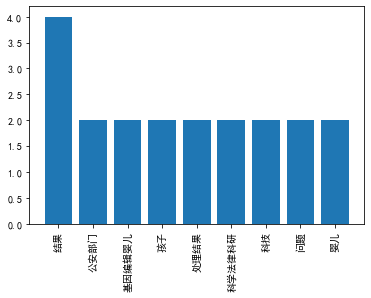

In [8]:
from pylab import *
mpl.rcParams['font.sans-serif']=['SimHei']

wa=dict(word_counts_top10)
plt.bar(wa.keys(),wa.values())
plt.xticks(rotation=90)
plt.show()

In [9]:
#从文件导入停用词表
stpwrdpath = "scu_stopwords.txt"
stpwrd_dic = open(stpwrdpath, 'rb')
stpwrd_content = stpwrd_dic.read().decode('utf-8')#将停用词表转换为list
stpwrdlst = stpwrd_content.splitlines()
stpwrd_dic.close()



In [10]:
# 调用sklearn机器学习包进行向量化
n_features = 1000 # 指定特征关键词提取最大值
tf_vectorizer = CountVectorizer(strip_accents='unicode',# 去除raw document中的重音符号
    max_features=n_features,#stop_words='english', # 停用词
    stop_words=stpwrdlst,
    max_df=0.5, # 阈值如果某个词的document frequence大于max_df，不当作关键词.float，词出现的次数与语料库文档数的百分比，int出现次数
    min_df=2) # 如果某个词的document frequence小于min_df，则这个词不会被当作关键词


tf = tf_vectorizer.fit_transform(df)
print(tf)
print('\nvocabulary list:\n\n',tf_vectorizer.get_feature_names())
print( '\nvocabulary dic :\n\n',tf_vectorizer.vocabulary_)

  (2, 1)	1
  (4, 2)	1
  (7, 5)	1
  (8, 3)	1
  (20, 7)	1
  (22, 3)	1
  (32, 8)	1
  (55, 10)	1
  (100, 4)	1
  (111, 5)	1
  (116, 0)	1
  (124, 8)	1
  (170, 0)	1
  (195, 9)	1
  (202, 1)	1
  (206, 9)	1
  (219, 10)	1
  (225, 7)	1
  (231, 4)	1
  (251, 2)	1
  (252, 6)	1
  (269, 6)	1

vocabulary list:

 ['人类', '公安部门', '基因编辑婴儿', '处理结果', '婴儿', '孩子', '疯子', '科学法律科研', '科技', '脑筋有点法则科学人们人类底线', '问题']

vocabulary dic :

 {'公安部门': 1, '基因编辑婴儿': 2, '孩子': 5, '处理结果': 3, '科学法律科研': 7, '科技': 8, '问题': 10, '婴儿': 4, '人类': 0, '脑筋有点法则科学人们人类底线': 9, '疯子': 6}


In [11]:
# LDA操作
n_topics = 5 # 人为指定划分的主题数
lda = LatentDirichletAllocation(n_topics,learning_method='online',max_iter=50,random_state=0 )
lda.fit(tf)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [12]:
# 显示主题关键词函数
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('\nTopic Nr.%d:' % int(topic_idx + 1))
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2)) + ' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))
n_top_words = 10 # 主题输出前20个关键词
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)





Topic Nr.1:
基因编辑婴儿 1.62 | 人类 1.62 | 科技 1.6 | 问题 0.2 | 疯子 0.2 | 孩子 0.2 | 公安部门 0.2 | 科学法律科研 0.2 | 婴儿 0.2 | 处理结果 0.2 | 

Topic Nr.2:
问题 1.62 | 处理结果 1.6 | 孩子 1.6 | 疯子 0.2 | 基因编辑婴儿 0.2 | 脑筋有点法则科学人们人类底线 0.2 | 人类 0.2 | 科学法律科研 0.2 | 婴儿 0.2 | 科技 0.2 | 

Topic Nr.3:
脑筋有点法则科学人们人类底线 1.64 | 科学法律科研 0.2 | 科技 0.2 | 孩子 0.2 | 处理结果 0.2 | 基因编辑婴儿 0.2 | 问题 0.2 | 疯子 0.2 | 人类 0.2 | 公安部门 0.2 | 

Topic Nr.4:
疯子 5.65 | 孩子 0.2 | 婴儿 0.2 | 科学法律科研 0.2 | 问题 0.2 | 人类 0.2 | 科技 0.2 | 公安部门 0.2 | 脑筋有点法则科学人们人类底线 0.2 | 处理结果 0.2 | 

Topic Nr.5:
婴儿 1.62 | 科学法律科研 1.62 | 公安部门 1.62 | 科技 0.2 | 基因编辑婴儿 0.2 | 问题 0.2 | 孩子 0.2 | 疯子 0.2 | 脑筋有点法则科学人们人类底线 0.2 | 人类 0.2 | 


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

data = pyLDAvis.sklearn.prepare(lda,tf,tf_vectorizer)

#让可视化可以在notebook内显示
pyLDAvis.show(data)



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8898/    [Ctrl-C to exit]


127.0.0.1 - - [30/Jun/2020 22:14:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Jun/2020 22:14:03] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [30/Jun/2020 22:14:03] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [30/Jun/2020 22:14:03] "GET /LDAvis.js HTTP/1.1" 200 -
